Выполнил - Кузьмин Андрей, tg - @thisismoto

Ссылка на collab: https://colab.research.google.com/drive/16TnFgo0SqHRB1X8nkIjsmUf8X1lRfscC#scrollTo=IRpL91bdOME3

# Проект - Мультимодальные банковские данные Юридических лиц

### Выбор и описание задачи

Команда Сбера выложила в open-source самый большой датасет, содержащий мультимодальные банковские данные ЮЛ.

 Multimodal Banking Dataset (MBD)

Датасет состоит из обезличенных исторических данных, содержащих следующую информацию по клиентам ЮЛ за 12-24 месяцев:
*   транзакционная активность (transactions);
*   эмбеддинги диалогов (dialogs);
*   гео-активность (geostream).

Таргет: предсказать для каждого пользователя взятие каждого из четырех продуктов в течение месяца после отчетнои‌ даты. Исторические данные за 2022 находятся в targets.

На текущей работе, я работаю с данным ЮЛ, на основе которых строятся разные склонностые модели в банке, поэтому было интересно проанализировать какие данные используются в дополнение к транзакционным на основе этого датасета сбера, чтобы улучшить качество текущих склонностных моделей в своем банке.

## Описание датасета и данных

https://huggingface.co/datasets/ai-lab/MBD-mini

**Dataset summary**

This dataset is designed to assist in predicting a customer's propensity to purchase various products within a month following the reporting date. The dataset includes anonymized historical data on transaction activity, dialog embeddings, and geo-activity for some bank clients over 12 months.

The mini MBD dataset contains a reduced subset of the data, making it easier and faster to work with during the development and testing phases. It includes a smaller number of clients and a shorter time span but maintains the same structure and features as the full dataset MBD. MBD-mini has data based on 10% of unique clients listed in MBD.

**Data**

The dataset consists of anonymized historical data, which contains the following information for some of the Bank's clients over 12 months:

transaction activity (transactions) Details about past transactions including amounts, types, and dates;
dialog embeddings (dialogs) Embeddings from customer interactions, which capture semantic information from dialogues;
geo-activity (geostream) Location-based data representing clients' geographic activity patterns.
Objective: To predict for each user the taking/not taking of each of the four products within a month after the reporting date, historical data for them is in targets

The dataset is divided into 5 folds based on client_split (which consist of an equal number of unique clients) for cross-validation purposes.

client_split Desc: Splitting clients into folds
* client_id: str Desc: Client id
* fold: int

detail
* dialog Desc: Dialogue embeddings
    * client_id: str Desc: Client id
    * event_time: timestamp Desc: Dialog's date
    * embedding: array float Desc: Dialog's embeddings
    * fold: int
* geo Desc: Geo activity
    * client_id: str Desc: Client id
    * event_time: timestamp Desc: Event datetime
    * fold: int
    * geohash_4: int Desc: Geohash level 4
    * geohash_5: int Desc: Geohash level 5
    * geohash_6: int Desc: Geohash level 6
* trx Desc: Transactional activity
    * client_id: str Desc: Client id
    * event_time: timestamp Desc: Transaction's date
    * amount: float Desc: Transaction's amount
    * fold: int
    * event_type: int Desc: Transaction's type
    * event_subtype: int Desc: Clarifying the transaction type
    * currency: int Desc: Currency
    * src_type11: int Desc: Feature 1 for sender
    * src_type12: int Desc: Clarifying feature 1 for sender
    * dst_type11: int Desc: Feature 1 for contractor
    * dst_type12: int Desc: Clarifying feature 1 for contractor
    * src_type21: int Desc: Feature 2 for sender
    * src_type22: int Desc: Clarifying feature 2 for sender
    * src_type31: int Desc: Feature 3 for sender
    * src_type32: int Desc: Clarifying feature 3 for sender

targets
* mon: str  Desc: Reporting month
* target_1: int Desc: Mark of product issuance in the first reporting month
* target_2: int Desc: Mark of product issuance in the second reporting month
* target_3: int Desc: Mark of product issuance in the third reporting month
* target_4: int Desc: Mark of product issuance in the fourth reporting month
* trans_count: int Desc: Number of transactions
* diff_trans_date: int Desc: Time difference between transactions
* client_id: str Desc: Client id
* fold: int


ptls Desc: Data is similar with detail but in pytorch-lifestream format https://github.com/dllllb/pytorch-lifestream

## Импорт библиотек

In [1]:
!pip install datasets pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd
import pyarrow
from datasets import load_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Сбор и обработка данных

В этой части загружается датасет с Hugging Face, распаковываются архивные файлы и выводится общая информация о содержимом директорий. После этого создается директория для распакованных файлов, если она не существует, и распаковываются все файлы формата tar.gz. В конце выводится список файлов в распакованной директории и определяются пути к конкретным файлам внутри неё.

In [3]:
from huggingface_hub import snapshot_download

# Скачиваем весь репозиторий датасета
snapshot_download(repo_id="ai-lab/MBD-mini", repo_type="dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/6.08k [00:00<?, ?B/s]

client_split.tar.gz:   0%|          | 0.00/4.18M [00:00<?, ?B/s]

targets.tar.gz:   0%|          | 0.00/7.93M [00:00<?, ?B/s]

detail.tar.gz:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

ptls.tar.gz:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3'

In [4]:
local_dir = '/root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3'

In [5]:
import os

# Проходимся по всем файлам и директориям в local_dir
for root, dirs, files in os.walk(local_dir):
    for name in dirs:
        print("Директория:", os.path.join(root, name))
    for name in files:
        print("Файл:", os.path.join(root, name))

Файл: /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/ptls.tar.gz
Файл: /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/client_split.tar.gz
Файл: /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/README.md
Файл: /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/targets.tar.gz
Файл: /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/.gitattributes
Файл: /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/detail.tar.gz


In [6]:
import os

# Список файлов в локальной директории
print("Файлы в local_dir:")
for file_name in os.listdir(local_dir):
    print(file_name)

Файлы в local_dir:
ptls.tar.gz
client_split.tar.gz
README.md
targets.tar.gz
.gitattributes
detail.tar.gz


In [7]:
# Путь к директории для распакованных файлов
extracted_data_dir = os.path.join(local_dir, 'extracted_data')

# Создаем директорию, если она не существует
os.makedirs(extracted_data_dir, exist_ok=True)

In [8]:
import tarfile

# Функция для распаковки tar.gz файлов
def extract_tar_gz(file_path, extract_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
        print(f"Распакован файл {os.path.basename(file_path)} в {extract_path}")

# Получаем список всех .tar.gz файлов в директории
tar_files = [f for f in os.listdir(local_dir) if f.endswith('.tar.gz')]

# Распаковываем каждый архив
for tar_file in tar_files:
    file_path = os.path.join(local_dir, tar_file)
    extract_tar_gz(file_path, extracted_data_dir)

Распакован файл ptls.tar.gz в /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/extracted_data
Распакован файл client_split.tar.gz в /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/extracted_data
Распакован файл targets.tar.gz в /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/extracted_data
Распакован файл detail.tar.gz в /root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/extracted_data


In [9]:
tar_files

['ptls.tar.gz', 'client_split.tar.gz', 'targets.tar.gz', 'detail.tar.gz']

In [10]:
# Выводим список файлов в директории с распакованными данными
for file_name in os.listdir(extracted_data_dir):
    print(file_name)

ptls
targets
detail
client_split


In [11]:
import os

In [12]:
extracted_data_dir = '/root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/extracted_data'

In [13]:
detail_file = os.path.join(extracted_data_dir, 'detail')
targets_file = os.path.join(extracted_data_dir, 'targets')
client_split_file = os.path.join(extracted_data_dir, 'client_split')

In [14]:
# Выводим список файлов и папок в 'detail'
print(os.listdir(detail_file))

['geo', 'dialog', 'trx']


## Транзакционные данные

Добавим импорт в некоторых частях, потому что перезаполняется ОЗУ

In [19]:
import pandas as pd
import os

extracted_data_dir = '/root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/extracted_data'
detail_file = os.path.join(extracted_data_dir, 'detail')
trx_path = os.path.join(detail_file, 'trx')
df_trx = pd.read_parquet(trx_path)

Сохраняем на диск

In [21]:
new_folder_path = '/content/drive/My Drive/MBD Project'

os.makedirs(new_folder_path, exist_ok=True)

In [22]:
trx_drive_path = '/content/drive/My Drive/MBD Project/trx.parquet'

df_trx.to_parquet(trx_drive_path)

In [ ]:
df_trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38764930 entries, 0 to 38764929
Data columns (total 15 columns):
 #   Column         Dtype         
---  ------         -----         
 0   client_id      object        
 1   event_time     datetime64[ns]
 2   amount         float32       
 3   event_type     int32         
 4   event_subtype  int32         
 5   currency       float64       
 6   src_type11     float64       
 7   src_type12     float64       
 8   dst_type11     float64       
 9   dst_type12     float64       
 10  src_type21     float64       
 11  src_type22     float64       
 12  src_type31     float64       
 13  src_type32     float64       
 14  fold           category      
dtypes: category(1), datetime64[ns](1), float32(1), float64(9), int32(2), object(1)
memory usage: 3.6+ GB


In [ ]:
# Просмотр первых нескольких строк
df_trx.head()

,client_id,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32,fold
0,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2022-10-26 13:58:59.938408,1.021543e+06,16,18,11.0,22.0,47.0,780.0,21619.0,21490.0,83.0,364.0,58.0,0
1,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2021-02-09 07:43:20.639579,3.007656e+05,1,12,11.0,4.0,958.0,306.0,26766.0,21490.0,83.0,364.0,58.0,0
2,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2022-10-22 09:12:06.614108,6.061549e+05,16,18,11.0,22.0,47.0,780.0,21619.0,21490.0,83.0,364.0,58.0,0
3,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2021-02-12 15:12:20.660481,8.032591e+04,1,12,11.0,4.0,958.0,306.0,26766.0,21490.0,83.0,364.0,58.0,0
4,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2022-10-08 06:52:28.877461,1.222866e+05,16,18,11.0,22.0,47.0,780.0,21619.0,21490.0,83.0,364.0,58.0,0


In [ ]:
df_trx.isnull().mean() * 100

,0
client_id,0.000000
event_time,0.000000
amount,0.000000
event_type,0.000000
event_subtype,0.000000
currency,0.000304
src_type11,0.560716
src_type12,0.560716
dst_type11,0.628981
dst_type12,0.628981


Видим что доля пропусков меньше 1 процента по всем переменным

In [ ]:
# Уникальные значения в столбце 'fold'
print("Уникальные фолды:", df_trx['fold'].unique())

# Количество записей в каждом фолде
fold_counts = df_trx['fold'].value_counts()
print("Количество записей в каждом фолде:\n", fold_counts)

Уникальные фолды: [0, 1, 2, 3, 4]
Categories (5, int32): [0, 1, 2, 3, 4]
Количество записей в каждом фолде:
 fold
3    8325008
1    8112842
0    7634228
4    7469149
2    7223703
Name: count, dtype: int64


In [ ]:
df_trx.describe(include = "all")

,client_id,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32,fold
count,38764930,38764930,3.876493e+07,3.876493e+07,3.876493e+07,3.876481e+07,3.854757e+07,3.854757e+07,3.852111e+07,3.852111e+07,3.872264e+07,3.872264e+07,3.868593e+07,3.868593e+07,38764930.0
unique,98721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
top,9162f460905b0c6838d781fb85f47616ae17e06ea3af99...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
freq,1020773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8325008.0
mean,NaN,2022-01-05 17:54:52.474897408,1.304900e+06,2.222725e+01,2.727393e+01,1.099689e+01,3.719957e+01,2.383623e+02,7.336910e+02,2.076017e+04,2.440500e+04,3.441446e+01,1.192344e+03,3.969164e+01,NaN
min,NaN,2020-12-31 21:00:02.169545,3.021821e-06,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,5.000000e+00,9.500000e+01,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN
25%,NaN,2021-07-07 06:10:24.942164224,2.453869e+03,1.000000e+00,1.200000e+01,1.100000e+01,2.200000e+01,4.700000e+01,3.060000e+02,1.606700e+04,1.330600e+04,8.000000e+00,5.500000e+02,1.900000e+01,NaN
50%,NaN,2021-12-31 18:24:54.437207040,1.803584e+04,1.100000e+01,1.900000e+01,1.100000e+01,2.200000e+01,4.700000e+01,7.800000e+02,2.161900e+04,2.420600e+04,2.500000e+01,1.127000e+03,3.500000e+01,NaN
75%,NaN,2022-07-10 06:00:49.388631296,9.475954e+04,4.600000e+01,4.000000e+01,1.100000e+01,2.200000e+01,4.650000e+02,7.930000e+02,2.676600e+04,3.640300e+04,5.400000e+01,1.846000e+03,6.000000e+01,NaN
max,NaN,2022-12-31 20:59:58.460193,1.370187e+12,5.600000e+01,6.200000e+01,1.700000e+01,1.860000e+02,1.143000e+03,1.753000e+03,3.305500e+04,4.892300e+04,8.800000e+01,2.506000e+03,8.900000e+01,NaN


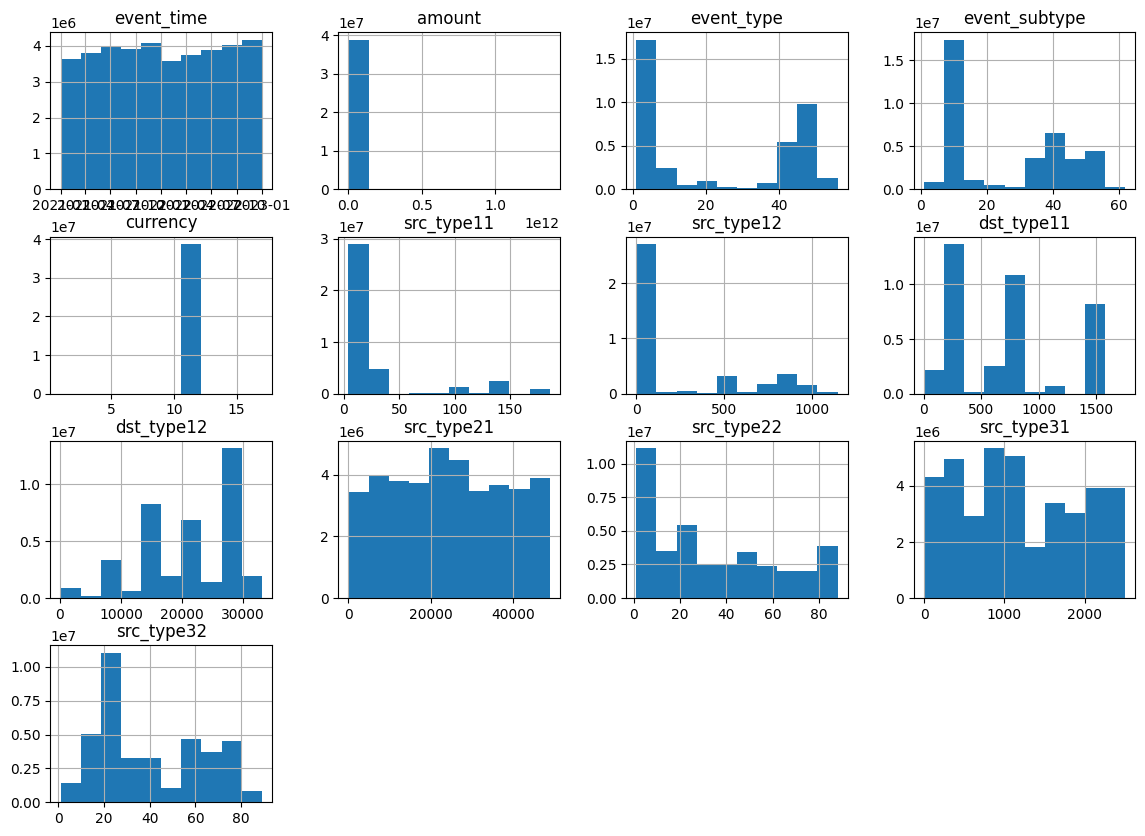

In [ ]:
df_trx.hist(figsize=(14, 10));

--- Анализ для фолда: 0 ---
                          event_time        amount    event_type  \
count                        7634228  7.634228e+06  7.634228e+06   
mean   2022-01-06 06:06:45.856158720  7.037678e+05  2.249315e+01   
min       2020-12-31 21:00:11.062887  1.168688e-05  1.000000e+00   
25%    2021-07-06 18:29:05.728897536  2.297636e+03  1.000000e+00   
50%    2022-01-02 08:07:45.843692800  1.666204e+04  1.300000e+01   
75%    2022-07-10 16:12:07.381889536  8.850691e+04  4.600000e+01   
max       2022-12-31 20:59:56.338108  8.811039e+10  5.600000e+01   
std                              NaN  6.396732e+07  2.126929e+01   

       event_subtype      currency    src_type11    src_type12    dst_type11  \
count   7.634228e+06  7.634192e+06  7.588765e+06  7.588765e+06  7.580026e+06   
mean    2.753563e+01  1.099737e+01  3.467387e+01  2.243373e+02  7.358390e+02   
min     1.000000e+00  1.000000e+00  4.000000e+00  1.000000e+00  5.000000e+00   
25%     1.200000e+01  1.100000e+01  2.2

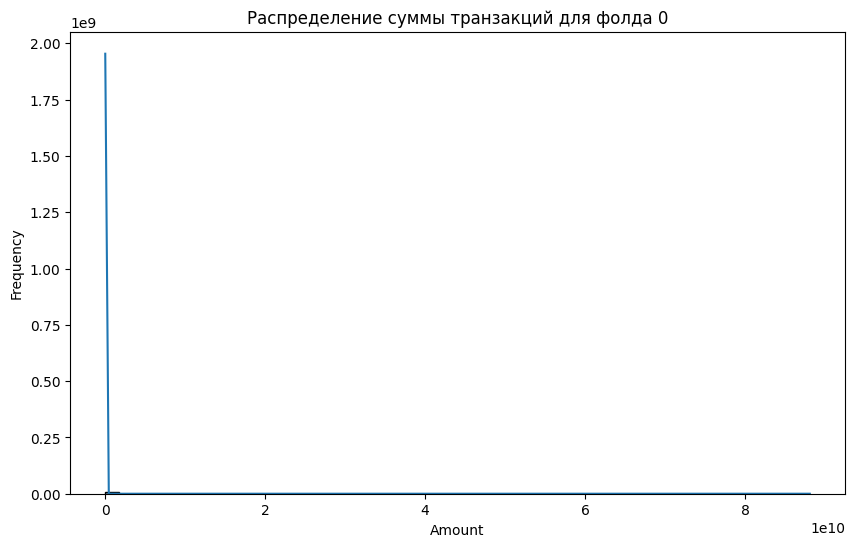

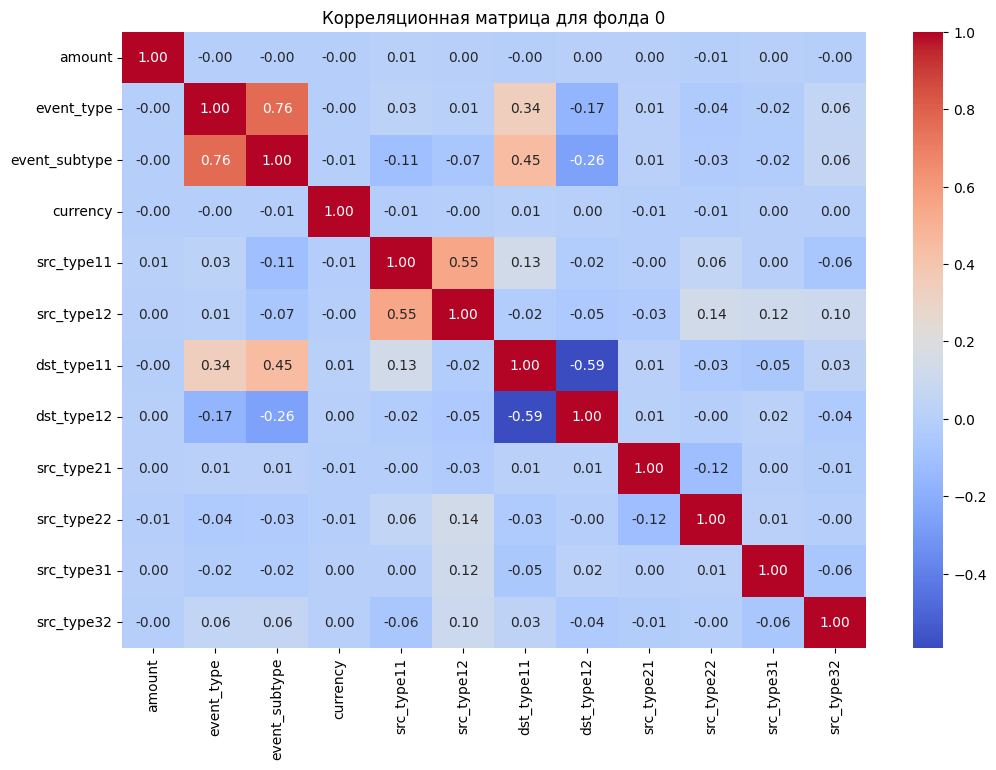

--- Анализ для фолда: 1 ---
                          event_time        amount    event_type  \
count                        8112842  8.112842e+06  8.112842e+06   
mean   2022-01-05 07:58:14.569772288  3.905566e+06  2.175286e+01   
min       2020-12-31 21:00:07.223020  3.018045e-05  1.000000e+00   
25%    2021-07-07 14:04:18.130005248  2.305425e+03  1.000000e+00   
50%    2021-12-31 06:09:00.028794880  1.696439e+04  1.100000e+01   
75%    2022-07-08 10:41:22.818539520  9.080300e+04  4.600000e+01   
max       2022-12-31 20:59:44.522033  1.370187e+12  5.600000e+01   
std                              NaN  1.045070e+09  2.124411e+01   

       event_subtype      currency    src_type11    src_type12    dst_type11  \
count   8.112842e+06  8.112839e+06  8.069379e+06  8.069379e+06  8.063969e+06   
mean    2.687758e+01  1.099512e+01  3.891620e+01  2.508719e+02  7.273813e+02   
min     1.000000e+00  1.000000e+00  4.000000e+00  1.000000e+00  5.000000e+00   
25%     1.200000e+01  1.100000e+01  2.2

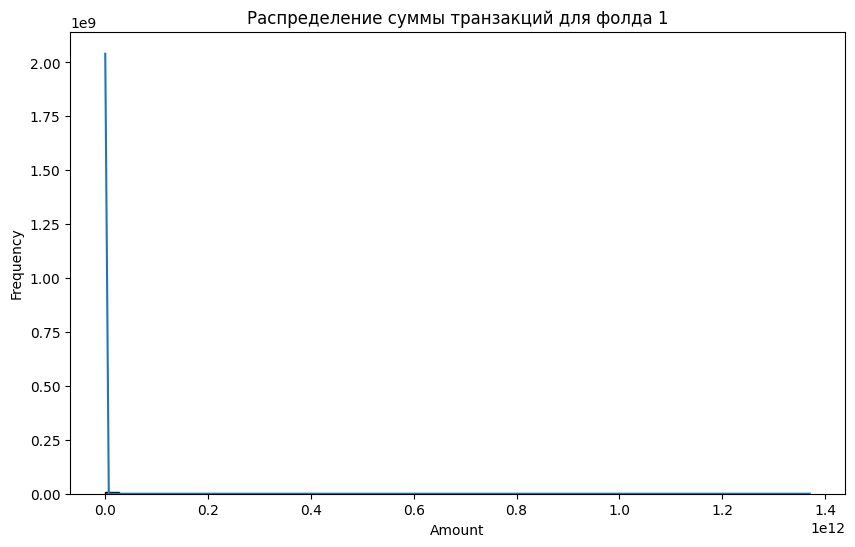

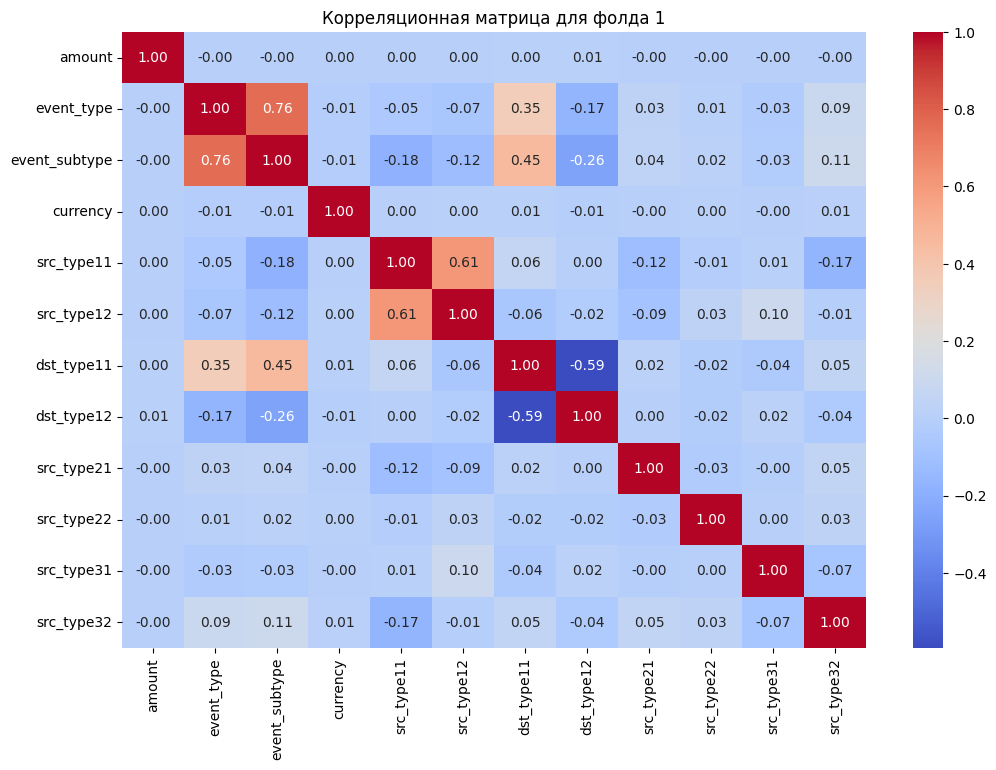

--- Анализ для фолда: 2 ---
                          event_time        amount    event_type  \
count                        7223703  7.223703e+06  7.223703e+06   
mean   2022-01-07 16:49:09.462548224  5.079293e+05  2.292374e+01   
min       2020-12-31 21:00:08.973426  3.021821e-06  1.000000e+00   
25%    2021-07-09 10:51:01.411931904  2.376219e+03  1.000000e+00   
50%    2022-01-03 22:13:19.206084096  1.747011e+04  1.500000e+01   
75%    2022-07-11 20:49:45.240857600  9.166143e+04  4.600000e+01   
max       2022-12-31 20:58:53.350541  4.435742e+10  5.600000e+01   
std                              NaN  2.589212e+07  2.123454e+01   

       event_subtype      currency    src_type11    src_type12    dst_type11  \
count   7.223703e+06  7.223700e+06  7.181215e+06  7.181215e+06  7.175943e+06   
mean    2.786427e+01  1.099683e+01  3.276346e+01  2.044579e+02  7.466685e+02   
min     1.000000e+00  1.000000e+00  4.000000e+00  1.000000e+00  5.000000e+00   
25%     1.200000e+01  1.100000e+01  2.2

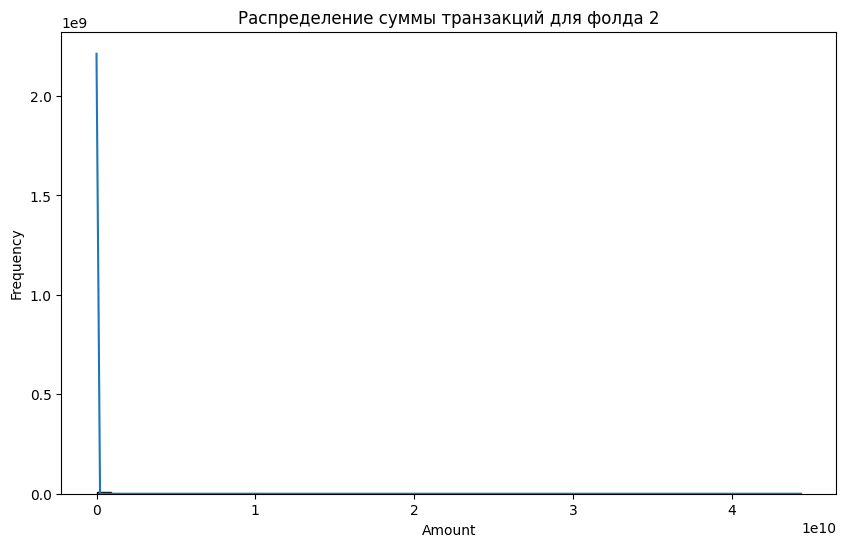

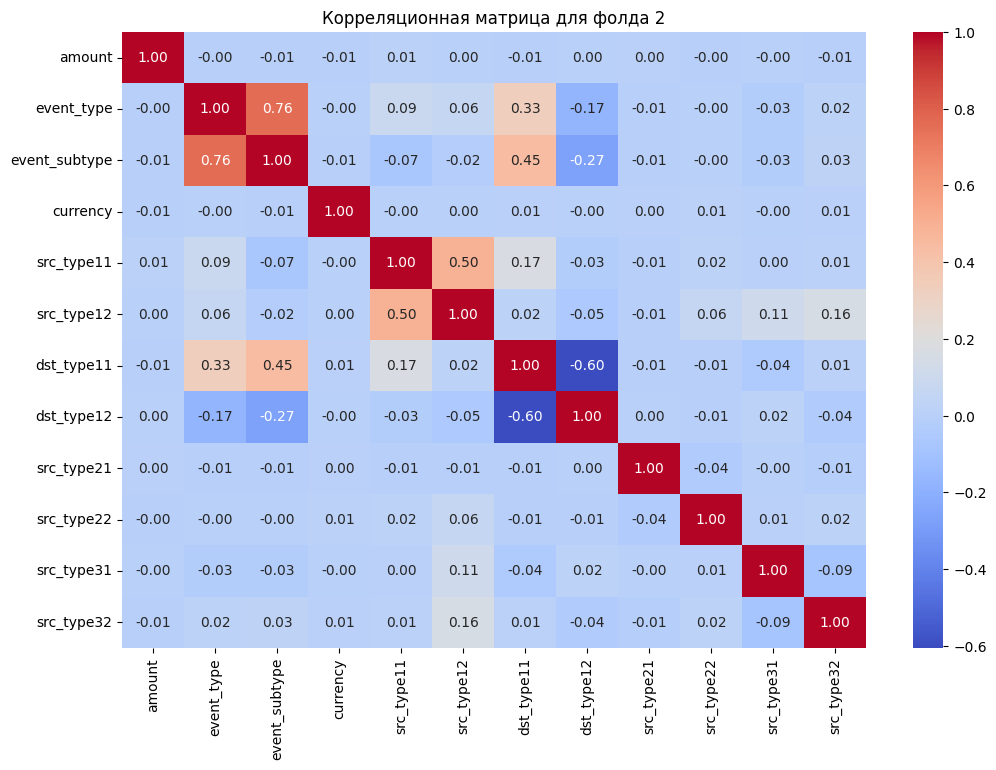

--- Анализ для фолда: 3 ---
                          event_time        amount    event_type  \
count                        8325008  8.325008e+06  8.325008e+06   
mean   2022-01-02 19:39:06.101384192  7.114198e+05  2.091689e+01   
min       2020-12-31 21:00:04.190445  1.272506e-05  1.000000e+00   
25%    2021-07-03 08:58:05.867067136  3.030041e+03  1.000000e+00   
50%    2021-12-26 19:16:54.321345024  2.258021e+04  1.100000e+01   
75%    2022-07-08 20:54:57.084995328  1.120432e+05  4.600000e+01   
max       2022-12-31 20:59:55.209194  1.249049e+11  5.600000e+01   
std                              NaN  7.542981e+07  2.121701e+01   

       event_subtype      currency    src_type11    src_type12    dst_type11  \
count   8.325008e+06  8.324932e+06  8.281341e+06  8.281341e+06  8.278664e+06   
mean    2.611372e+01  1.099779e+01  4.567171e+01  2.962450e+02  7.182206e+02   
min     1.000000e+00  1.000000e+00  4.000000e+00  1.000000e+00  5.000000e+00   
25%     1.200000e+01  1.100000e+01  2.2

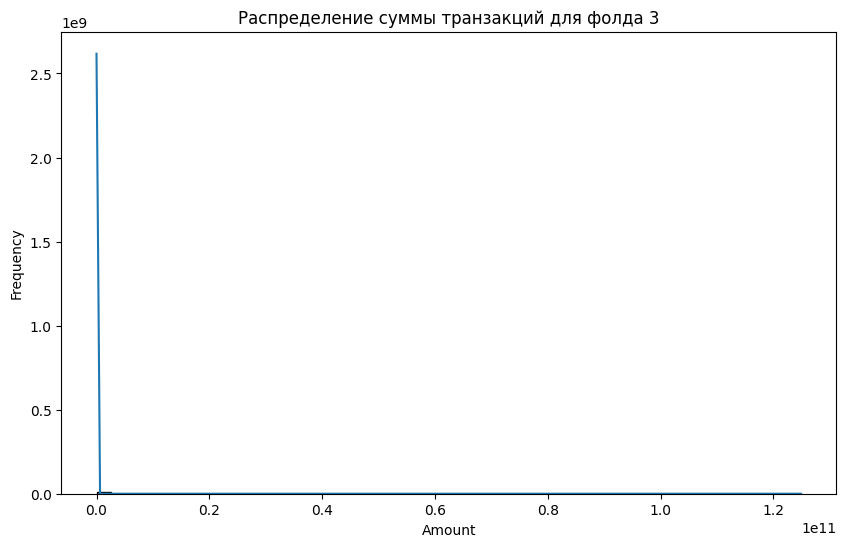

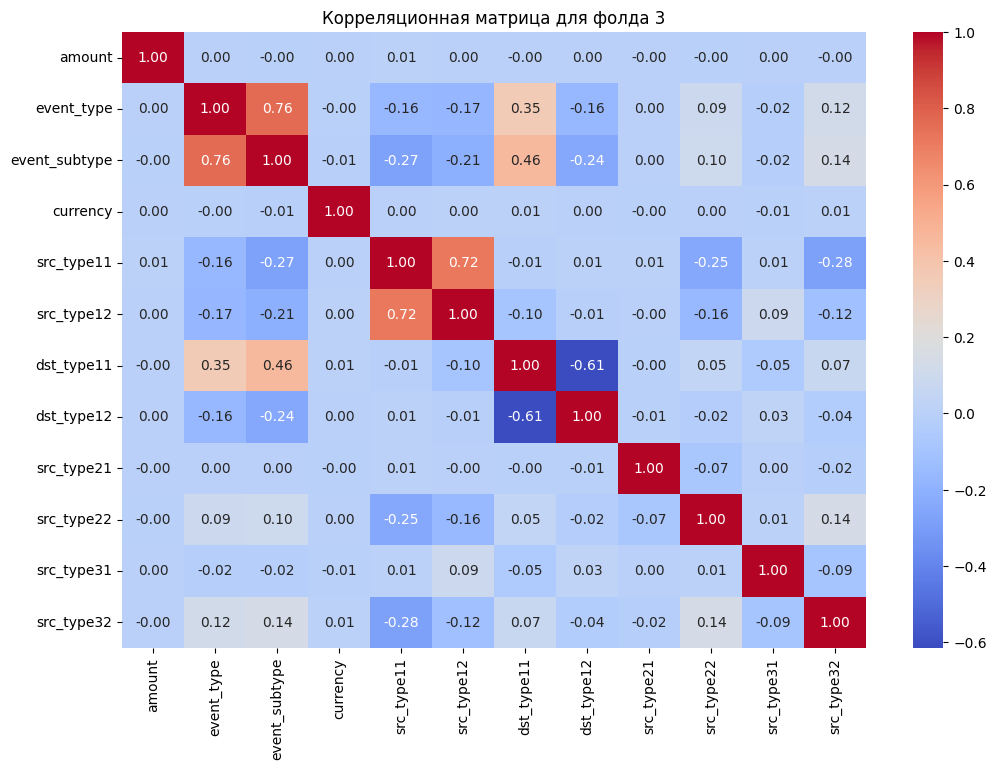

--- Анализ для фолда: 4 ---
                          event_time        amount    event_type  \
count                        7469149  7.469149e+06  7.469149e+06   
mean   2022-01-07 01:11:53.850944768  5.267979e+05  2.325766e+01   
min       2020-12-31 21:00:02.169545  2.391978e-05  1.000000e+00   
25%    2021-07-08 20:38:34.792562944  2.321552e+03  1.000000e+00   
50%    2022-01-03 05:23:48.764879104  1.683995e+04  1.800000e+01   
75%    2022-07-10 15:31:57.751300096  8.840760e+04  4.600000e+01   
max       2022-12-31 20:59:58.460193  2.402767e+10  5.600000e+01   
std                              NaN  2.229190e+07  2.130491e+01   

       event_subtype      currency    src_type11    src_type12    dst_type11  \
count   7.469149e+06  7.469149e+06  7.426869e+06  7.426869e+06  7.422504e+06   
mean    2.815919e+01  1.099739e+01  3.275770e+01  2.073420e+02  7.430609e+02   
min     1.000000e+00  3.000000e+00  4.000000e+00  1.000000e+00  5.000000e+00   
25%     1.200000e+01  1.100000e+01  2.2

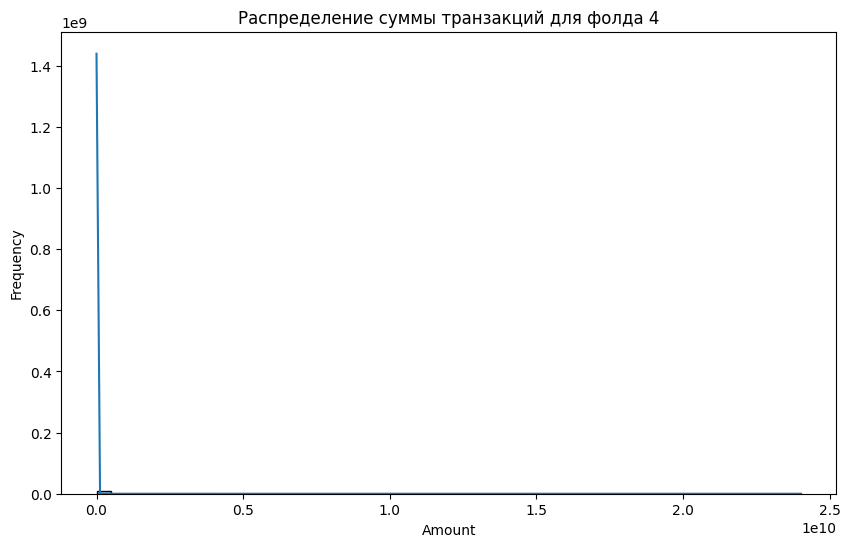

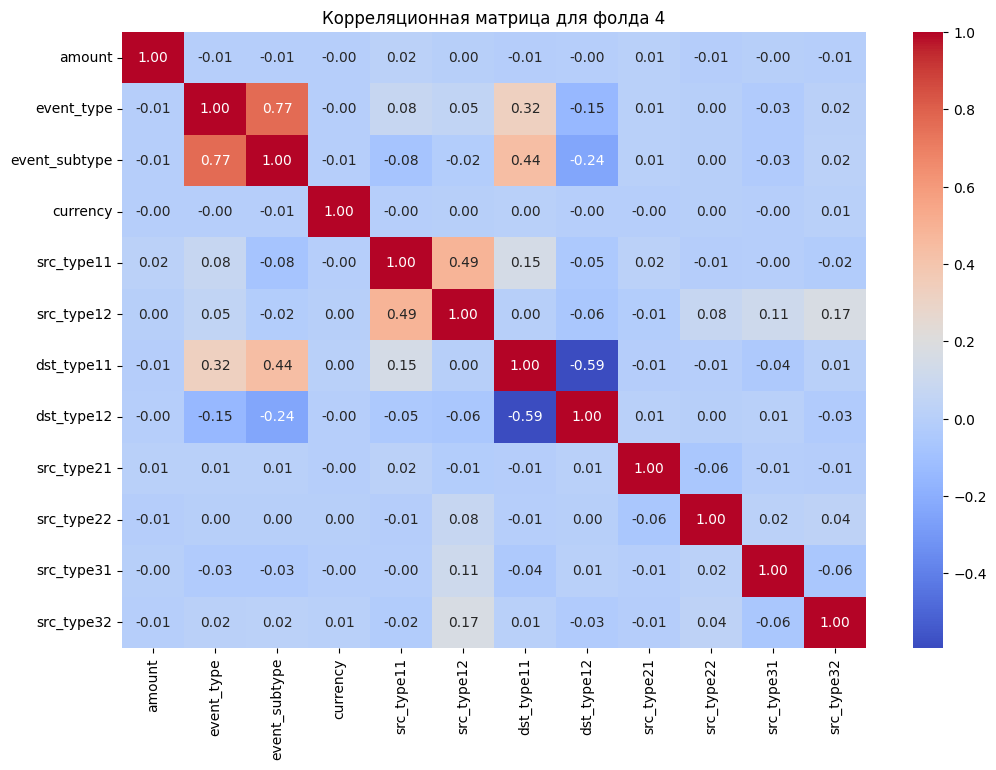

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Получаем список уникальных фолдов
folds = df_trx['fold'].cat.categories.tolist()

for fold in folds:
    print(f"--- Анализ для фолда: {fold} ---")

    # Отбираем данные текущего фолда
    df_fold = df_trx[df_trx['fold'] == fold].copy()

    # Основные статистические показатели
    print(df_fold.describe())

    print("Число дубликатов:\n", df_fold.duplicated().sum())

    # Проверка пропущенных значений
    missing_values = df_fold.isnull().sum()
    print("Пропущенные значения:\n", missing_values)

    # Распределение суммы транзакций
    plt.figure(figsize=(10,6))
    sns.histplot(df_fold['amount'], bins=50, kde=True)
    plt.title(f'Распределение суммы транзакций для фолда {fold}')
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    plt.show()

    # Корреляционный анализ
    numeric_cols = df_fold.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns
    corr_matrix = df_fold[numeric_cols].corr()
    plt.figure(figsize=(12,8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title(f'Корреляционная матрица для фолда {fold}')
    plt.show()

    # Дополнительный анализ по необходимости...

    # Освобождаем память от временного DataFrame
    del df_fold

Общая предварительная оценка данных:
- набор данных достаточен для интеллектуального анализа
- есть пропуски, но они меньше 1 процента, аномалии и выбросы
- явных дубликатов нет, неправильных типов нет.

In [23]:
del df_trx

## Геоданные

In [1]:
import pandas as pd
import os

extracted_data_dir = '/root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/extracted_data'
detail_file = os.path.join(extracted_data_dir, 'detail')
geo_path = os.path.join(detail_file, 'geo')
df_geo = pd.read_parquet(geo_path)

Сохраняем на диск

In [12]:
geo_drive_path = '/content/drive/My Drive/MBD Project/geo.parquet'

df_geo.to_parquet(geo_drive_path)

In [ ]:
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66295724 entries, 0 to 66295723
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   client_id   object        
 1   event_time  datetime64[ns]
 2   geohash_4   int32         
 3   geohash_5   int32         
 4   geohash_6   int32         
 5   fold        category      
dtypes: category(1), datetime64[ns](1), int32(3), object(1)
memory usage: 1.8+ GB


In [ ]:
df_geo.head()

,client_id,event_time,geohash_4,geohash_5,geohash_6,fold
0,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-03-25 13:39:51.569288,41342,406579,1018528,0
1,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-06-11 07:21:32.505485,41342,406579,1018528,0
2,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-08-08 21:25:07.461323,41342,406579,1018528,0
3,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-07-23 11:32:03.433401,41342,406579,1018528,0
4,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-05-28 08:18:19.843885,41342,406579,1018528,0


In [ ]:
df_geo.isnull().mean() * 100

,0
client_id,0.0
event_time,0.0
geohash_4,0.0
geohash_5,0.0
geohash_6,0.0
fold,0.0


Доля пропусков меньше процента

In [ ]:
# Уникальные значения в столбце 'fold'
print("Уникальные фолды:", df_geo['fold'].unique())

# Количество записей в каждом фолде
fold_counts = df_geo['fold'].value_counts()
print("Количество записей в каждом фолде:\n", fold_counts)

Уникальные фолды: [0, 1, 2, 3, 4]
Categories (5, int32): [0, 1, 2, 3, 4]
Количество записей в каждом фолде:
 fold
0    13814561
3    13208817
4    13161123
2    13155672
1    12955551
Name: count, dtype: int64


In [ ]:
df_geo.describe(include = "all")

,client_id,event_time,geohash_4,geohash_5,geohash_6,fold
count,66295724,66295724,6.629572e+07,6.629572e+07,6.629572e+07,66295724.0
unique,72573,NaN,NaN,NaN,NaN,5.0
top,572f99a0e826b63a99197a8789e599879c391e3e4a155f...,NaN,NaN,NaN,NaN,0.0
freq,39487,NaN,NaN,NaN,NaN,13814561.0
mean,NaN,2022-06-30 18:29:37.444508160,2.123069e+04,2.163122e+05,1.463469e+06,NaN
min,NaN,2021-12-11 19:27:07.507106,1.200000e+01,5.000000e+00,1.000000e+00,NaN
25%,NaN,2022-04-01 08:31:08.213744384,6.911000e+03,1.144170e+05,7.268480e+05,NaN
50%,NaN,2022-06-30 04:38:04.015493376,2.069500e+04,2.163810e+05,1.465135e+06,NaN
75%,NaN,2022-09-25 17:50:37.378558720,3.301500e+04,3.178810e+05,2.201893e+06,NaN
max,NaN,2022-12-31 20:59:58.725788,5.380800e+04,4.280580e+05,2.936555e+06,NaN


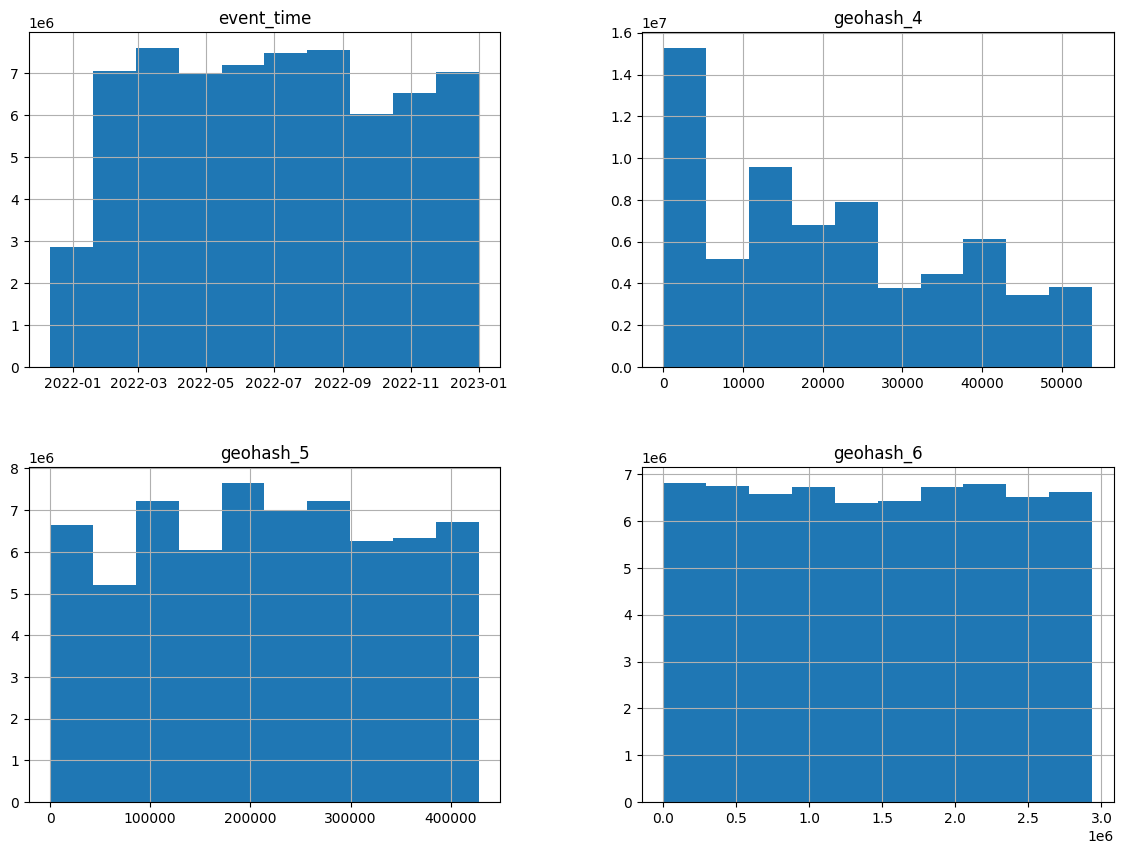

In [ ]:
df_geo.hist(figsize=(14, 10));

In [ ]:
!pip install geohash2

  Preparing metadata (setup.py) ... done
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15543 sha256=db62de7bad7b126024aeda6fd8c6b75f198b19306782ec9a7140d05994c50e4f
  Stored in directory: /root/.cache/pip/wheels/c0/21/8d/fe65503f4f439aef35193e5ec10a14adc945e20ff87eb35895
Successfully built geohash2


In [ ]:
import pandas as pd
import geohash2
import folium
from folium.plugins import HeatMap

# Функция для преобразования геохеша в координаты
def geohash_to_coordinates(geohash_code):
    lat, lon = geohash2.decode(geohash_code)
    return lat, lon

df_fold = df_geo[df_geo['fold'] == 1].copy()

# Преобразуем geohash_6 в строковый формат
df_fold['geohash_6_str'] = df_fold['geohash_6'].astype(str)

# Получаем координаты
df_fold[['latitude', 'longitude']] = df_fold['geohash_6_str'].apply(lambda x: pd.Series(geohash_to_coordinates(x)))

# Выбираем подвыборку (например, 100000 записей) для визуализации
df_sample = df_fold.sample(n=100000)

# Создаём карту
map_center = [df_sample['latitude'].mean(), df_sample['longitude'].mean()]
heatmap_map = folium.Map(location=map_center, zoom_start=6)

# Подготавливаем данные для тепловой карты
heat_data = list(zip(df_sample['latitude'], df_sample['longitude']))

# Добавляем тепловую карту
HeatMap(heat_data, radius=8, max_zoom=13).add_to(heatmap_map)

# Сохраняем карту в файл
heatmap_map.save('heatmap.html')

In [ ]:
del df_geo, df_fold

NameError: name 'df_geo' is not defined

## Эмбендинги диалогов

In [6]:
import pandas as pd
import os

extracted_data_dir = '/root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/extracted_data'
detail_file = os.path.join(extracted_data_dir, 'detail')
dialog_path = os.path.join(detail_file, 'dialog')
df_dialog = pd.read_parquet(dialog_path)

Сохраняем на диск

In [11]:
dialog_drive_path = '/content/drive/My Drive/MBD Project/dialog.parquet'

df_dialog.to_parquet(dialog_drive_path)

NameError: name 'df_dialog' is not defined

In [ ]:
df_dialog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217205 entries, 0 to 217204
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   217205 non-null  object        
 1   event_time  217205 non-null  datetime64[ns]
 2   embedding   217205 non-null  object        
 3   fold        217205 non-null  category      
dtypes: category(1), datetime64[ns](1), object(2)
memory usage: 5.2+ MB


In [ ]:
df_dialog.head()

,client_id,event_time,embedding,fold
0,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2021-06-18 05:49:23.962741,"[0.39314136, -0.0361106, 0.31113446, -0.197847...",0
1,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2022-06-29 07:39:31.618769,"[0.30220613, -0.38150322, 0.47271872, -0.28499...",0
2,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2022-06-24 06:06:59.691367,"[0.5709108, -0.39508772, 0.54685795, -0.413398...",0
3,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2021-05-12 12:34:32.616245,"[0.23272727, -0.28448686, 0.5841493, -0.524621...",0
4,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2021-10-25 05:25:17.810891,"[0.31696838, -0.14973284, 0.42603743, -0.39549...",0


In [ ]:
len(df_dialog['embedding'][100])

768

Длина эмбендингов 768

In [ ]:
df_dialog.isnull().mean() * 100

,0
client_id,0.0
event_time,0.0
embedding,0.0
fold,0.0


Пропусков нет

In [ ]:
# Уникальные значения в столбце 'fold'
print("Уникальные фолды:", df_dialog['fold'].unique())

# Количество записей в каждом фолде
fold_counts = df_dialog['fold'].value_counts()
print("Количество записей в каждом фолде:\n", fold_counts)

Уникальные фолды: [0, 1, 2, 3, 4]
Categories (5, int32): [0, 1, 2, 3, 4]
Количество записей в каждом фолде:
 fold
4    44046
2    43737
0    43561
1    42953
3    42908
Name: count, dtype: int64


In [ ]:
df_dialog.describe()

,event_time
count,217205
mean,2022-02-25 15:06:58.270022656
min,2021-02-10 09:36:07.022271
25%,2021-08-31 05:31:56.381040896
50%,2022-03-10 12:32:21.479177984
75%,2022-08-28 09:01:05.186578944
max,2022-12-31 20:25:11.730797


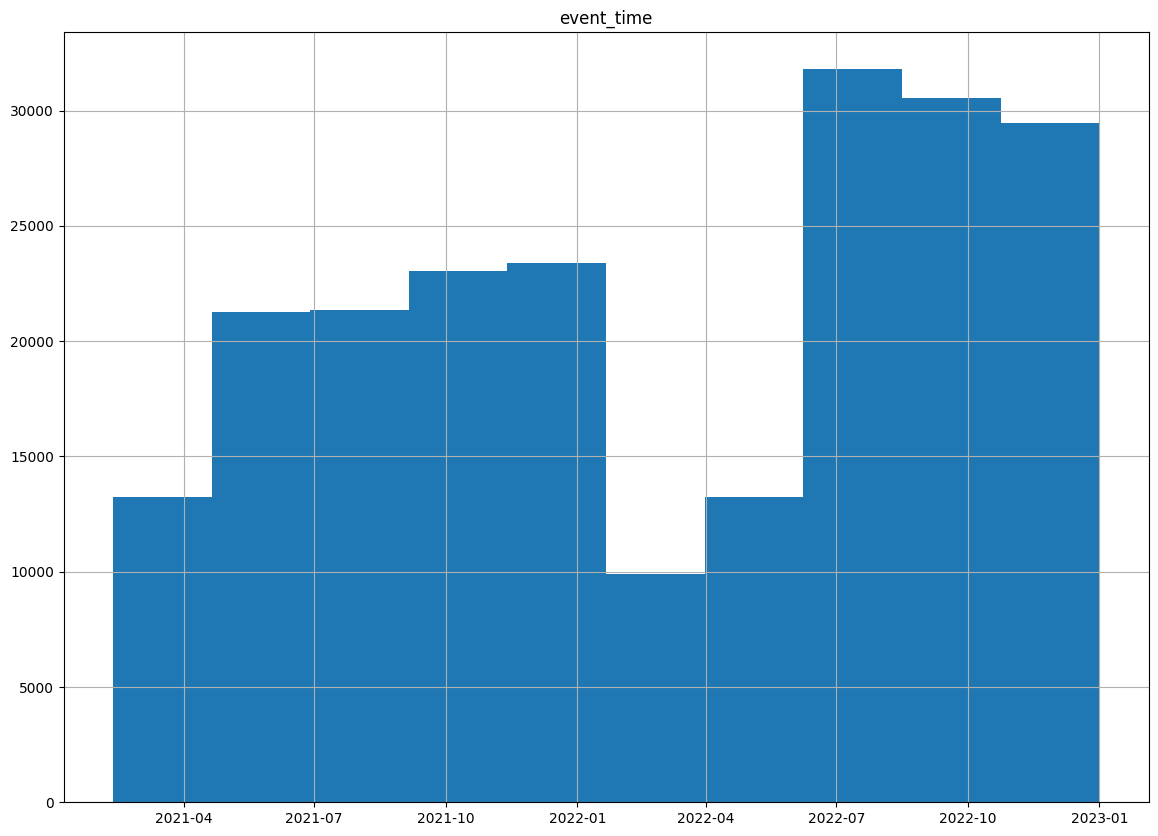

In [ ]:
df_dialog.hist(figsize=(14, 10));

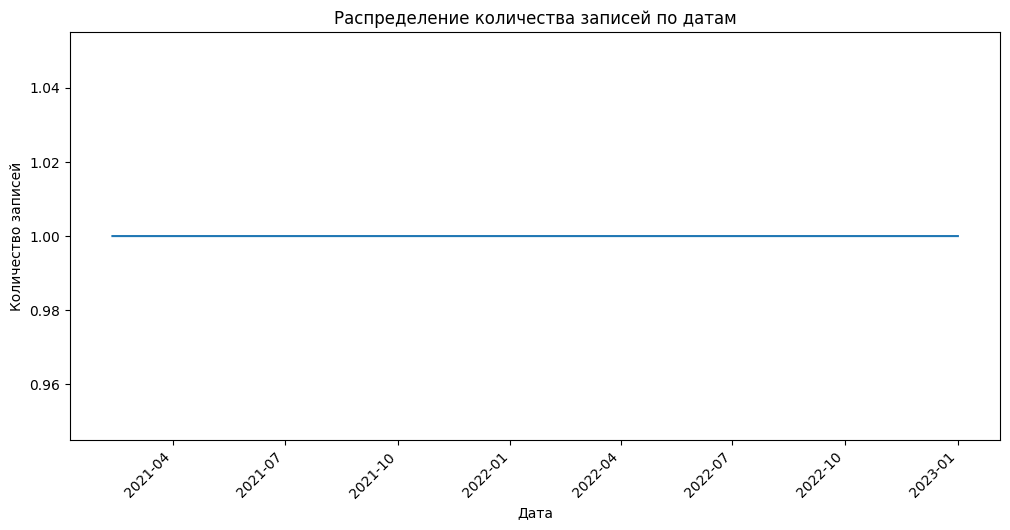

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


date_counts = df_dialog.groupby('event_time').size()

# Построение графика распределения количества записей во времени
plt.figure(figsize=(12,6))
date_counts.plot()
plt.title(f'Распределение количества записей по датам')
plt.xlabel('Дата')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.show()

In [8]:
del df_dialog

## Таргет

In [9]:
import pandas as pd
import os

extracted_data_dir = '/root/.cache/huggingface/hub/datasets--ai-lab--MBD-mini/snapshots/4b0d5b4c0b014e02af6c2e6b7b27851e6fb0d5c3/extracted_data'
targets_file = os.path.join(extracted_data_dir, 'targets')
df_tg = pd.read_parquet(targets_file)

Сохраняем на диск

In [10]:
target_drive_path = '/content/drive/My Drive/MBD Project/target.parquet'

df_tg.to_parquet(target_drive_path)

In [ ]:
df_tg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202688 entries, 0 to 1202687
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   client_id        1202688 non-null  object  
 1   mon              1202688 non-null  object  
 2   target_1         1202688 non-null  int32   
 3   target_2         1202688 non-null  int32   
 4   target_3         1202688 non-null  int32   
 5   target_4         1202688 non-null  int32   
 6   trans_count      1202688 non-null  int32   
 7   diff_trans_date  1081902 non-null  float64 
 8   fold             1202688 non-null  category
dtypes: category(1), float64(1), int32(5), object(2)
memory usage: 51.6+ MB


In [ ]:
df_tg.head()

,client_id,mon,target_1,target_2,target_3,target_4,trans_count,diff_trans_date,fold
0,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-02-28,0,0,0,0,10,0.0,0
1,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-03-31,0,0,0,0,29,0.0,0
2,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-04-30,0,0,0,0,51,0.0,0
3,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-05-31,0,0,0,0,52,4.0,0
4,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-06-30,0,0,0,0,52,35.0,0


In [ ]:
df_tg.isnull().mean() * 100

,0
client_id,0.000000
mon,0.000000
target_1,0.000000
target_2,0.000000
target_3,0.000000
target_4,0.000000
trans_count,0.000000
diff_trans_date,10.043004
fold,0.000000


In [ ]:
# Уникальные значения в столбце 'fold'
print("Уникальные фолды:", df_tg['fold'].unique())

# Количество записей в каждом фолде
fold_counts = df_tg['fold'].value_counts()
print("Количество записей в каждом фолде:\n", fold_counts)

Уникальные фолды: [0, 1, 2, 3, 4]
Categories (5, int32): [0, 1, 2, 3, 4]
Количество записей в каждом фолде:
 fold
0    243936
4    240720
3    240204
2    239004
1    238824
Name: count, dtype: int64


In [ ]:
df_tg.describe(include = "all")

,client_id,mon,target_1,target_2,target_3,target_4,trans_count,diff_trans_date,fold
count,1202688,1202688,1.202688e+06,1.202688e+06,1.202688e+06,1.202688e+06,1.202688e+06,1.081902e+06,1202688.0
unique,100224,12,NaN,NaN,NaN,NaN,NaN,NaN,5.0
top,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-02-28,NaN,NaN,NaN,NaN,NaN,NaN,0.0
freq,12,100224,NaN,NaN,NaN,NaN,NaN,NaN,243936.0
mean,NaN,NaN,4.458347e-03,4.797587e-04,3.766563e-03,2.544301e-03,9.608587e+01,1.919688e+01,NaN
std,NaN,NaN,6.662187e-02,2.189815e-02,6.125667e-02,5.037687e-02,1.464933e+02,4.462332e+01,NaN
min,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,NaN
50%,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+01,3.000000e+00,NaN
75%,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.210000e+02,1.400000e+01,NaN


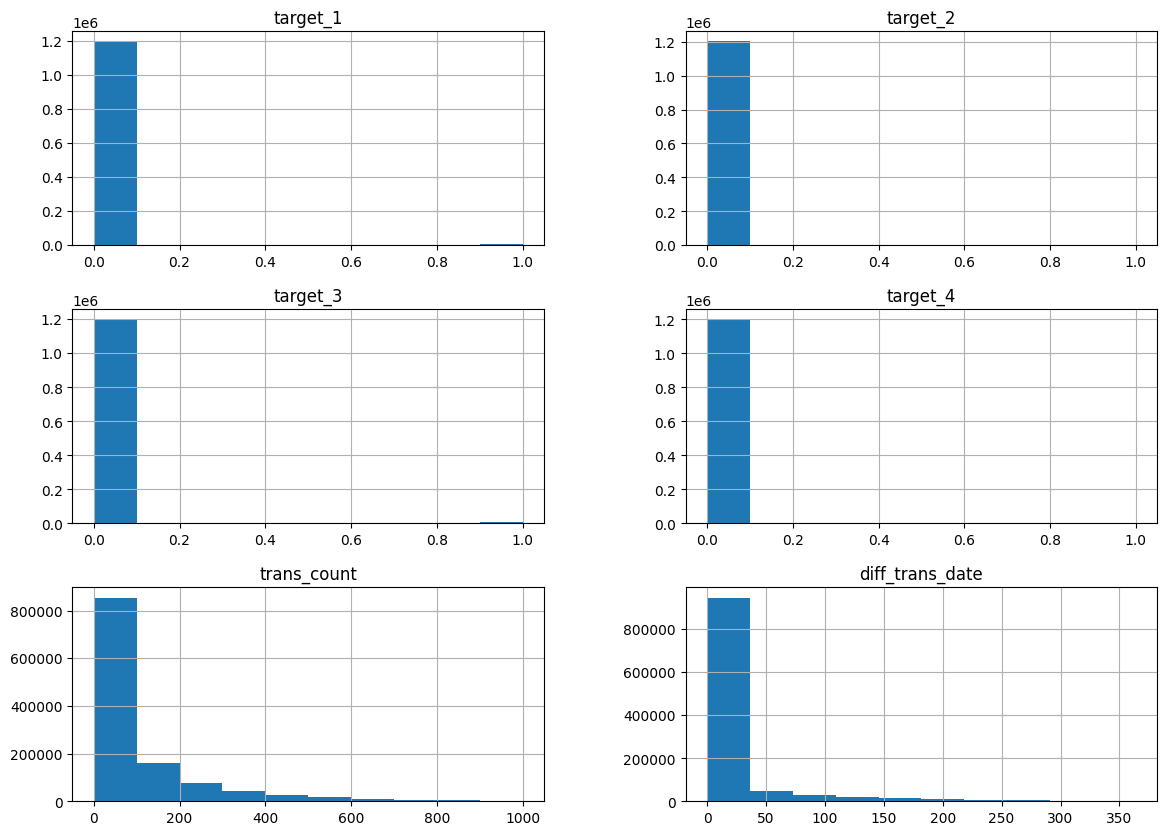

In [ ]:
df_tg.hist(figsize=(14, 10));

In [ ]:
del df_tg

#База данных

## Создадим базу данных

In [7]:
import pyarrow.parquet as pq
import pandas as pd
import sqlite3

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
trx_drive_path = '/content/drive/My Drive/MBD Project/trx.parquet'

geo_drive_path = '/content/drive/My Drive/MBD Project/geo.parquet'

dialog_drive_path = '/content/drive/My Drive/MBD Project/dialog.parquet'

target_drive_path = '/content/drive/My Drive/MBD Project/target.parquet'

In [22]:
def save_parquet_to_sqlite_in_chunks(parquet_path, table_name, db_name='my_database.db', chunk_size=50000):
    # Открываем файл Parquet
    parquet_file = pq.ParquetFile(parquet_path)

    # Создаем подключение к базе данных SQLite
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    # Обрабатываем данные по частям
    for batch in parquet_file.iter_batches(batch_size=chunk_size):
        df = batch.to_pandas()
        df.to_sql(table_name, conn, if_exists='append', index=False)
        del df

    # Закрываем подключение к базе данных
    conn.close()
    print(f"Таблица '{table_name}' успешно сохранена в базе данных '{db_name}'.")

# Пути к файлам на Google Диске
trx_drive_path = '/content/drive/My Drive/MBD Project/trx.parquet'

# Сохранение каждой таблицы по очереди
save_parquet_to_sqlite_in_chunks(trx_drive_path, 'trx')

Таблица 'trx' успешно сохранена в базе данных 'my_database.db'.


In [4]:
save_parquet_to_sqlite_in_chunks(geo_drive_path, 'geo')

Таблица 'geo' успешно сохранена в базе данных 'my_database.db'.


In [5]:
save_parquet_to_sqlite_in_chunks(dialog_drive_path, 'dialog')

Таблица 'dialog' успешно сохранена в базе данных 'my_database.db'.


In [6]:
save_parquet_to_sqlite_in_chunks(target_drive_path, 'target')

Таблица 'target' успешно сохранена в базе данных 'my_database.db'.


In [7]:
import shutil

shutil.move('my_database.db', '/content/drive/My Drive/MBD Project/my_database.db')

'/content/drive/My Drive/MBD Project/my_database.db'

## Тест

In [9]:
conn = sqlite3.connect('/content/drive/My Drive/MBD Project/my_database.db')

# Выполнение SQL-запроса для извлечения данных
query = "SELECT * FROM trx limit 5"
df = pd.read_sql_query(query, conn)

# Закрытие подключения к базе данных
conn.close()

df

,client_id,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32,fold
0,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2022-10-26 13:58:59.938408,1.021543e+06,16,18,11.0,22.0,47.0,780.0,21619.0,21490.0,83.0,364.0,58.0,0
1,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2021-02-09 07:43:20.639579,3.007656e+05,1,12,11.0,4.0,958.0,306.0,26766.0,21490.0,83.0,364.0,58.0,0
2,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2022-10-22 09:12:06.614108,6.061549e+05,16,18,11.0,22.0,47.0,780.0,21619.0,21490.0,83.0,364.0,58.0,0
3,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2021-02-12 15:12:20.660481,8.032591e+04,1,12,11.0,4.0,958.0,306.0,26766.0,21490.0,83.0,364.0,58.0,0
4,01a1aca1531e0d86b605759fedd36e1855f41a8a6a49b4...,2022-10-08 06:52:28.877461,1.222866e+05,16,18,11.0,22.0,47.0,780.0,21619.0,21490.0,83.0,364.0,58.0,0


In [14]:
conn = sqlite3.connect('/content/drive/My Drive/MBD Project/my_database.db')

# Выполнение SQL-запроса для извлечения данных
query = "SELECT * FROM geo limit 5"
df = pd.read_sql_query(query, conn)

# Закрытие подключения к базе данных
conn.close()

df

,client_id,event_time,geohash_4,geohash_5,geohash_6,fold
0,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-03-25 13:39:51.569288,41342,406579,1018528,0
1,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-06-11 07:21:32.505485,41342,406579,1018528,0
2,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-08-08 21:25:07.461323,41342,406579,1018528,0
3,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-07-23 11:32:03.433401,41342,406579,1018528,0
4,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-05-28 08:18:19.843885,41342,406579,1018528,0


In [15]:
conn = sqlite3.connect('/content/drive/My Drive/MBD Project/my_database.db')

# Выполнение SQL-запроса для извлечения данных
query = "SELECT * FROM dialog limit 5"
df = pd.read_sql_query(query, conn)

# Закрытие подключения к базе данных
conn.close()

df

,client_id,event_time,embedding,fold
0,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2021-06-18 05:49:23.962741,b'\xd3I\xc9>\xb5\xe8\x13\xbd\x04M\x9f>\x85\x98...,0
1,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2022-06-29 07:39:31.618769,b'\xc3\xba\x9a>dT\xc3\xbe0\x08\xf2>b\xea\x91\x...,0
2,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2022-06-24 06:06:59.691367,b'6\'\x12?\xf0H\xca\xbe\xe2\xfe\x0b?\xfa\xa8\x...,0
3,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2021-05-12 12:34:32.616245,b'\x0fPn>C\xa8\x91\xbe\xcf\x8a\x15?\x9fM\x06\x...,0
4,5226901c78c655767ac2a075e6edca6b410624f0c9d2fd...,2021-10-25 05:25:17.810891,b'\xaeI\xa2>\x91S\x19\xbe\x94!\xda>\xce}\xca\x...,0


In [16]:
conn = sqlite3.connect('/content/drive/My Drive/MBD Project/my_database.db')

# Выполнение SQL-запроса для извлечения данных
query = "SELECT * FROM target limit 5"
df = pd.read_sql_query(query, conn)

# Закрытие подключения к базе данных
conn.close()

df

,client_id,mon,target_1,target_2,target_3,target_4,trans_count,diff_trans_date,fold
0,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-02-28,0,0,0,0,10,0.0,0
1,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-03-31,0,0,0,0,29,0.0,0
2,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-04-30,0,0,0,0,51,0.0,0
3,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-05-31,0,0,0,0,52,4.0,0
4,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-06-30,0,0,0,0,52,35.0,0


Все работает

 # Качество данных

Проверка таблицы trx

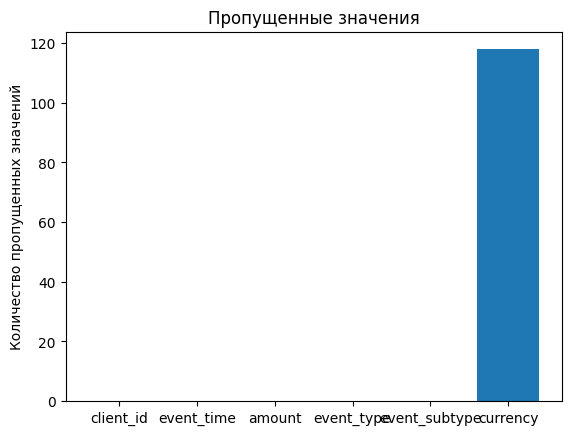

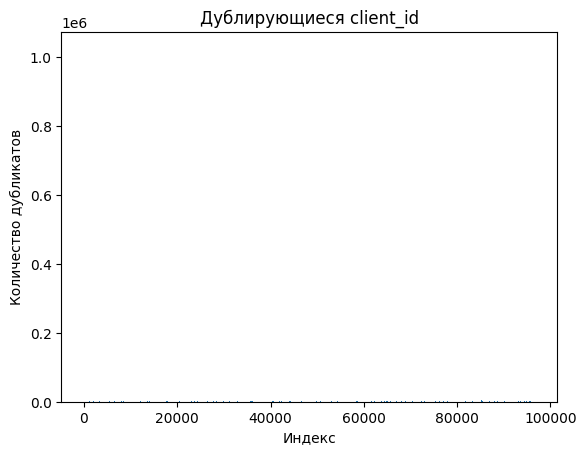

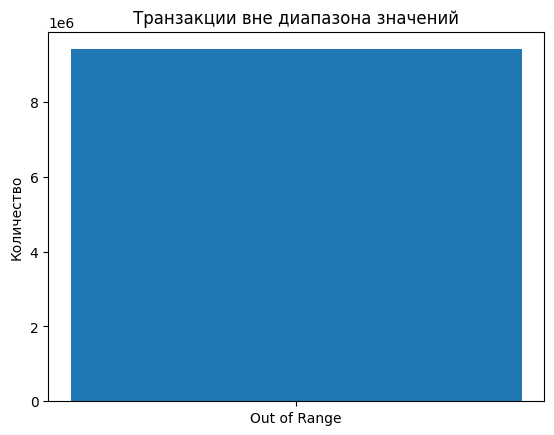

In [23]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

# Подключение к базе данных SQLite
conn = sqlite3.connect('/content/drive/My Drive/MBD Project/my_database.db')
cursor = conn.cursor()

# Проверка на пропущенные значения
missing_values_query = """
SELECT
    SUM(CASE WHEN client_id IS NULL THEN 1 ELSE 0 END) AS missing_client_id,
    SUM(CASE WHEN event_time IS NULL THEN 1 ELSE 0 END) AS missing_event_time,
    SUM(CASE WHEN amount IS NULL THEN 1 ELSE 0 END) AS missing_amount,
    SUM(CASE WHEN event_type IS NULL THEN 1 ELSE 0 END) AS missing_event_type,
    SUM(CASE WHEN event_subtype IS NULL THEN 1 ELSE 0 END) AS missing_event_subtype,
    SUM(CASE WHEN currency IS NULL THEN 1 ELSE 0 END) AS missing_currency
FROM trx;
"""
cursor.execute(missing_values_query)
missing_values = cursor.fetchone()

# Визуализация пропущенных значений
columns = ['client_id', 'event_time', 'amount', 'event_type', 'event_subtype', 'currency']
plt.bar(columns, missing_values)
plt.title('Пропущенные значения')
plt.ylabel('Количество пропущенных значений')
plt.show()

# Проверка уникальности
unique_check_query = """
SELECT
    client_id,
    COUNT(client_id) AS count
FROM trx
GROUP BY client_id
HAVING count > 1;
"""
cursor.execute(unique_check_query)
duplicates = cursor.fetchall()

# Визуализация дублирующихся client_id
if duplicates:
    duplicate_counts = [dup[1] for dup in duplicates]
    plt.bar(range(len(duplicates)), duplicate_counts)
    plt.title('Дублирующиеся client_id')
    plt.xlabel('Индекс')
    plt.ylabel('Количество дубликатов')
    plt.show()
else:
    print("Все client_id уникальны.")

# Проверка диапазонов значений
range_check_query = """
SELECT
    COUNT(*) AS out_of_range_count
FROM trx
WHERE amount < 0 OR amount > 100000;
"""
cursor.execute(range_check_query)
out_of_range_count = cursor.fetchone()[0]

# Визуализация диапазонов значений
plt.bar(['Out of Range'], [out_of_range_count])
plt.title('Транзакции вне диапазона значений')
plt.ylabel('Количество')
plt.show()

# Закрытие подключения к базе данных
conn.close()

Проверка таблицы geo

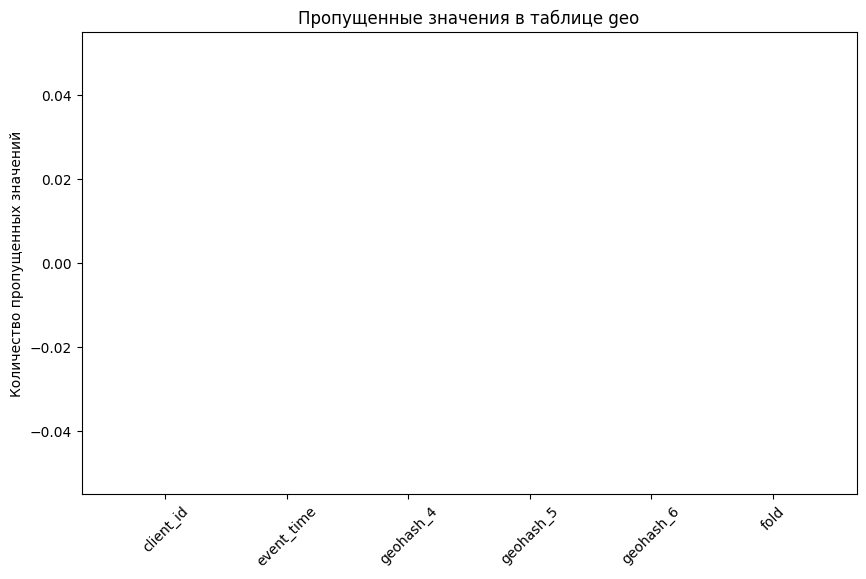

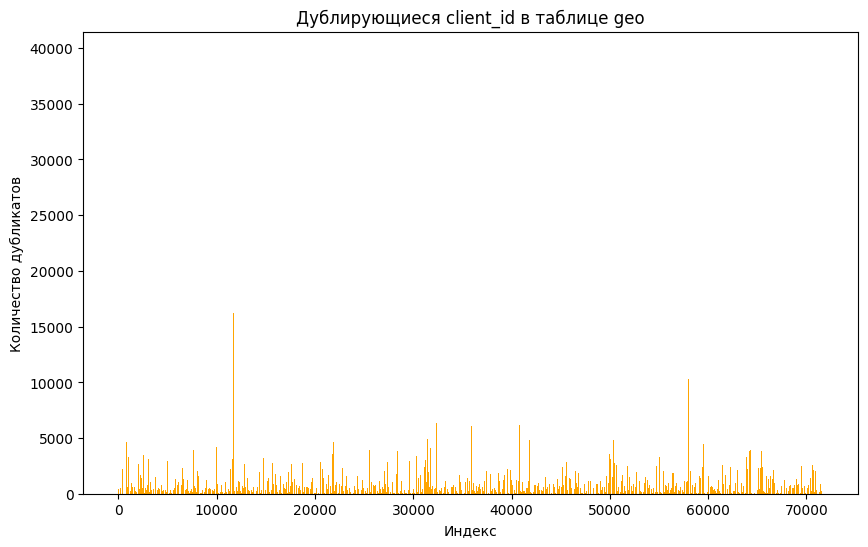

In [24]:
import sqlite3
import matplotlib.pyplot as plt

# Подключение к базе данных SQLite
conn = sqlite3.connect('/content/drive/My Drive/MBD Project/my_database.db')
cursor = conn.cursor()

# Проверка на пропущенные значения
missing_values_query_geo = """
SELECT
    SUM(CASE WHEN client_id IS NULL THEN 1 ELSE 0 END) AS missing_client_id,
    SUM(CASE WHEN event_time IS NULL THEN 1 ELSE 0 END) AS missing_event_time,
    SUM(CASE WHEN geohash_4 IS NULL THEN 1 ELSE 0 END) AS missing_geohash_4,
    SUM(CASE WHEN geohash_5 IS NULL THEN 1 ELSE 0 END) AS missing_geohash_5,
    SUM(CASE WHEN geohash_6 IS NULL THEN 1 ELSE 0 END) AS missing_geohash_6,
    SUM(CASE WHEN fold IS NULL THEN 1 ELSE 0 END) AS missing_fold
FROM geo;
"""
cursor.execute(missing_values_query_geo)
missing_values_geo = cursor.fetchone()

# Визуализация пропущенных значений
columns_geo = ['client_id', 'event_time', 'geohash_4', 'geohash_5', 'geohash_6', 'fold']
plt.figure(figsize=(10, 6))
plt.bar(columns_geo, missing_values_geo, color='skyblue')
plt.title('Пропущенные значения в таблице geo')
plt.ylabel('Количество пропущенных значений')
plt.xticks(rotation=45)
plt.show()

# Проверка уникальности
unique_check_query_geo = """
SELECT
    client_id,
    COUNT(client_id) AS count
FROM geo
GROUP BY client_id
HAVING count > 1;
"""
cursor.execute(unique_check_query_geo)
duplicates_geo = cursor.fetchall()

# Визуализация дублирующихся client_id
if duplicates_geo:
    duplicate_counts_geo = [dup[1] for dup in duplicates_geo]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(duplicates_geo)), duplicate_counts_geo, color='orange')
    plt.title('Дублирующиеся client_id в таблице geo')
    plt.xlabel('Индекс')
    plt.ylabel('Количество дубликатов')
    plt.show()
else:
    print("Все client_id уникальны.")

# Закрытие подключения к базе данных
conn.close()

Проверка таблицы dialog

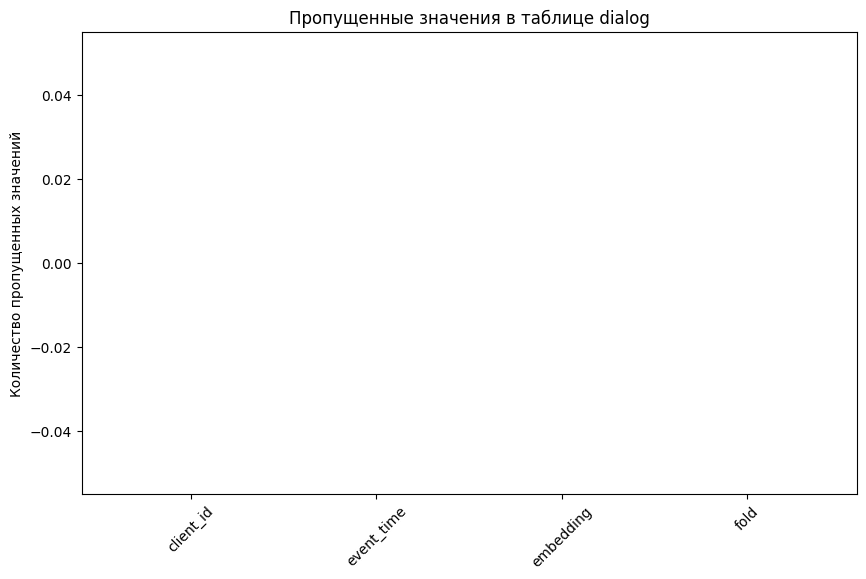

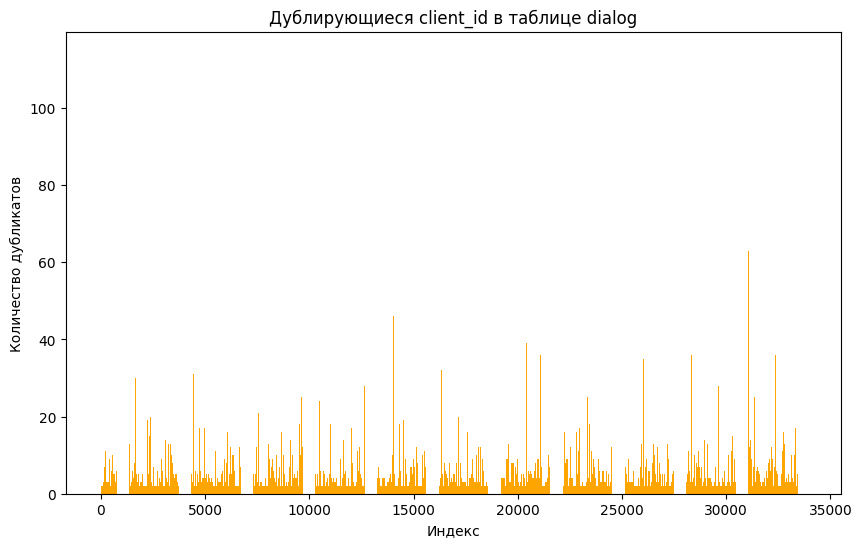

In [25]:
import sqlite3
import matplotlib.pyplot as plt

# Подключение к базе данных SQLite
conn = sqlite3.connect('/content/drive/My Drive/MBD Project/my_database.db')
cursor = conn.cursor()

# Проверка на пропущенные значения
missing_values_query_dialog = """
SELECT
    SUM(CASE WHEN client_id IS NULL THEN 1 ELSE 0 END) AS missing_client_id,
    SUM(CASE WHEN event_time IS NULL THEN 1 ELSE 0 END) AS missing_event_time,
    SUM(CASE WHEN embedding IS NULL THEN 1 ELSE 0 END) AS missing_embedding,
    SUM(CASE WHEN fold IS NULL THEN 1 ELSE 0 END) AS missing_fold
FROM dialog;
"""
cursor.execute(missing_values_query_dialog)
missing_values_dialog = cursor.fetchone()

# Визуализация пропущенных значений
columns_dialog = ['client_id', 'event_time', 'embedding', 'fold']
plt.figure(figsize=(10, 6))
plt.bar(columns_dialog, missing_values_dialog, color='skyblue')
plt.title('Пропущенные значения в таблице dialog')
plt.ylabel('Количество пропущенных значений')
plt.xticks(rotation=45)
plt.show()

# Проверка уникальности
unique_check_query_dialog = """
SELECT
    client_id,
    COUNT(client_id) AS count
FROM dialog
GROUP BY client_id
HAVING count > 1;
"""
cursor.execute(unique_check_query_dialog)
duplicates_dialog = cursor.fetchall()

# Визуализация дублирующихся client_id
if duplicates_dialog:
    duplicate_counts_dialog = [dup[1] for dup in duplicates_dialog]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(duplicates_dialog)), duplicate_counts_dialog, color='orange')
    plt.title('Дублирующиеся client_id в таблице dialog')
    plt.xlabel('Индекс')
    plt.ylabel('Количество дубликатов')
    plt.show()
else:
    print("Все client_id уникальны.")

# Закрытие подключения к базе данных
conn.close()

Проверка таблицы target

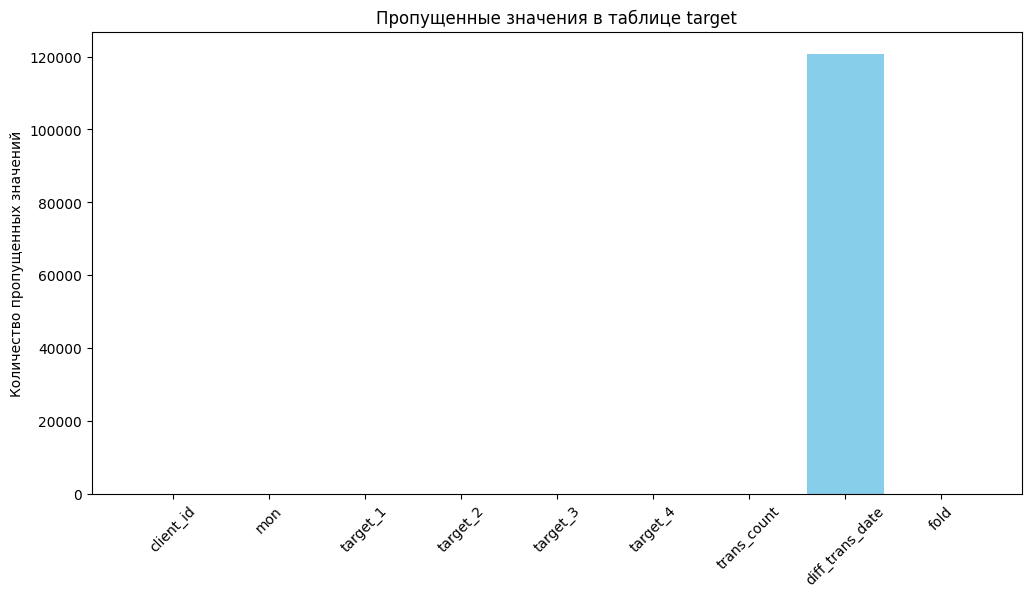

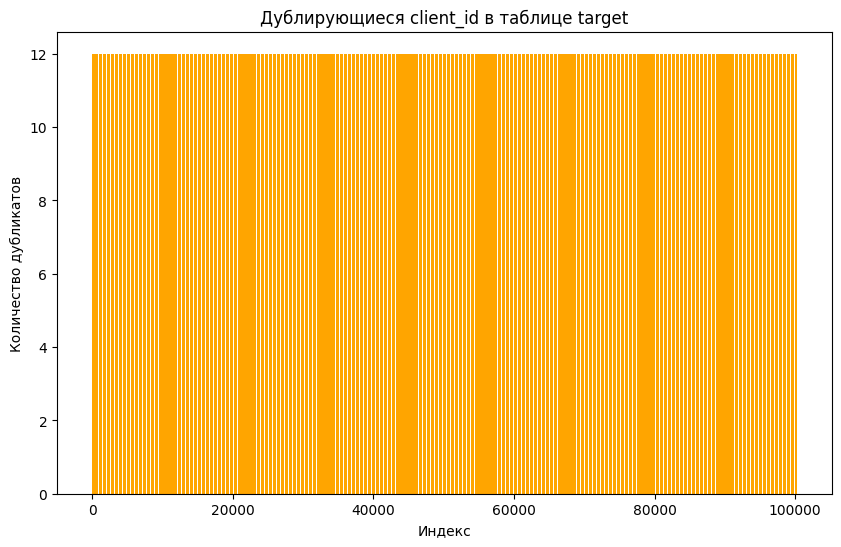

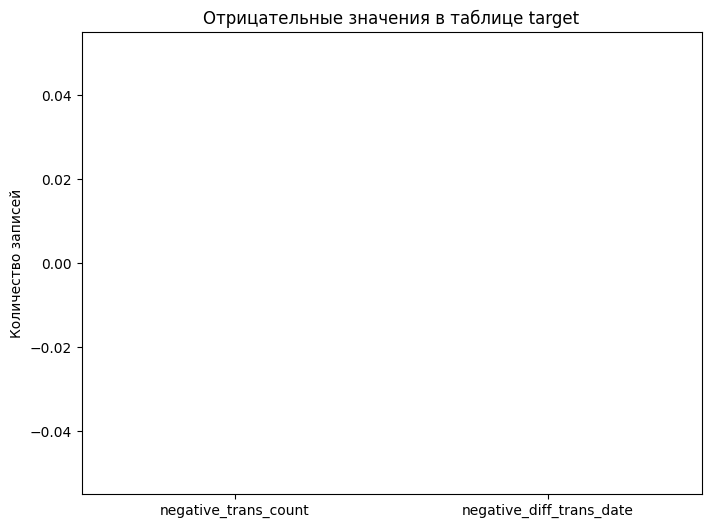

In [26]:
# Подключение к базе данных SQLite
conn = sqlite3.connect('/content/drive/My Drive/MBD Project/my_database.db')
cursor = conn.cursor()

# Проверка на пропущенные значения
missing_values_query_target = """
SELECT
    SUM(CASE WHEN client_id IS NULL THEN 1 ELSE 0 END) AS missing_client_id,
    SUM(CASE WHEN mon IS NULL THEN 1 ELSE 0 END) AS missing_mon,
    SUM(CASE WHEN target_1 IS NULL THEN 1 ELSE 0 END) AS missing_target_1,
    SUM(CASE WHEN target_2 IS NULL THEN 1 ELSE 0 END) AS missing_target_2,
    SUM(CASE WHEN target_3 IS NULL THEN 1 ELSE 0 END) AS missing_target_3,
    SUM(CASE WHEN target_4 IS NULL THEN 1 ELSE 0 END) AS missing_target_4,
    SUM(CASE WHEN trans_count IS NULL THEN 1 ELSE 0 END) AS missing_trans_count,
    SUM(CASE WHEN diff_trans_date IS NULL THEN 1 ELSE 0 END) AS missing_diff_trans_date,
    SUM(CASE WHEN fold IS NULL THEN 1 ELSE 0 END) AS missing_fold
FROM target;
"""
cursor.execute(missing_values_query_target)
missing_values_target = cursor.fetchone()

# Визуализация пропущенных значений
columns_target = ['client_id', 'mon', 'target_1', 'target_2', 'target_3', 'target_4', 'trans_count', 'diff_trans_date', 'fold']
plt.figure(figsize=(12, 6))
plt.bar(columns_target, missing_values_target, color='skyblue')
plt.title('Пропущенные значения в таблице target')
plt.ylabel('Количество пропущенных значений')
plt.xticks(rotation=45)
plt.show()

# Проверка уникальности
unique_check_query_target = """
SELECT
    client_id,
    COUNT(client_id) AS count
FROM target
GROUP BY client_id
HAVING count > 1;
"""
cursor.execute(unique_check_query_target)
duplicates_target = cursor.fetchall()

# Визуализация дублирующихся client_id
if duplicates_target:
    duplicate_counts_target = [dup[1] for dup in duplicates_target]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(duplicates_target)), duplicate_counts_target, color='orange')
    plt.title('Дублирующиеся client_id в таблице target')
    plt.xlabel('Индекс')
    plt.ylabel('Количество дубликатов')
    plt.show()
else:
    print("Все client_id уникальны.")

# Проверка диапазонов значений
range_check_query_target = """
SELECT
    SUM(CASE WHEN trans_count < 0 THEN 1 ELSE 0 END) AS negative_trans_count,
    SUM(CASE WHEN diff_trans_date < 0 THEN 1 ELSE 0 END) AS negative_diff_trans_date
FROM target;
"""
cursor.execute(range_check_query_target)
negative_values_target = cursor.fetchone()

# Визуализация диапазонов значений
plt.figure(figsize=(8, 6))
plt.bar(['negative_trans_count', 'negative_diff_trans_date'], negative_values_target, color='red')
plt.title('Отрицательные значения в таблице target')
plt.ylabel('Количество записей')
plt.show()

# Закрытие подключения к базе данных
conn.close()

## Выводы и описание используемых подходов
- Для анализа использовались методы: построение гистограмм для каждой переменной, вывода долей пропусков по каждой из переменной в модуле, это нужно для ее последующего отбора в обучающую выборку, также выводилось общее и статистическое описание датасета через команды info и describe, выводилось количество записей по датам - данные распределены нормально. Также в транзакционном модуле рассмотрена аналитика по фолдам, чтобы избежать перезаполнения ОЗУ, проверялась корреляция, дубликы, здесь все в рамках допустимых значений.
- Данные являются предобработанными и готовыми к обучению модели
- Данные и само название признаков обезличино, поэтому глуже проанализировать данные было невозможно
- Количество пропусков меньше процента, что является нормальным значением для дальнейго обучения модели
- Данные распределены нормально для построения модели склонности оформления банковских продуктов
- Создана база данных в SQLite, что обеспечивает удобное хранение и доступ к данным для последующего анализа и использования в моделях машинного обучения
- Была автоматизирована проверка качества данных, что позволяет быстро и эффективно выявлять и устранять потенциальные проблемы в датасете.